In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from itertools import combinations, product
from time import time

In [2]:
def calculate_average(*args,**kwargs):
    return np.mean(args)

In [3]:
def calculate_cost(data: np.ndarray) -> np.ndarray:
    costs = cdist(data[:,2].reshape(-1,1), data[:,2].reshape(-1,1),calculate_average)
    distances = np.round(cdist(data[:,:2], data[:,:2], 'euclidean'))
    distances = distances + costs
    return distances

In [4]:
def candidate_moves(distances: np.ndarray, k=10) -> np.ndarray:
    candidates = np.zeros(distances.shape, dtype=bool)
    idx = np.argpartition(distances, k, axis=-1)[:, :k]
    candidates[np.repeat(range(distances.shape[0]), k), idx.flatten()] = True
    return candidates

In [5]:
def random_initial_solution(data, distances):
    ind = list(range(len(data)))
    i = random.randrange(len(ind))
    limit = len(data) // 2
    order = [ind[i]]
    while(len(ind) > limit):
        ind = np.delete(ind, i, 0)
        i = random.randrange(len(ind))
        order.append(ind[i])
    return order

In [6]:
def create_neighborhood(order, total, inter=False):
    ind = list(range(len(order)))
    if inter:
        # inter-route: one selected, one not selected
        not_selected = np.setdiff1d(list(range(total)), order)
        inter_route = [[0] + list(x) for x in list(product(ind, not_selected))]
        return inter_route
    else:
        # intra-route:
        intra = list(combinations(ind, 2))
        # node exchange:
        node_ex = [[1] + list(x) for x in intra]
        # edge exchange:
        edge_ex = [[2] + list(x) for x in intra]
        return node_ex + edge_ex
#     return inter_route + node_ex + edge_ex

In [7]:
def calculate_value(data, distances, ordr):
    order = ordr.copy()
    order.append(order[0])
    value = sum([distances[x][y] for x, y in zip(order, order[1:])])
    path = [data[i] for i in order]
    return value, path

In [8]:
def local_search_greedy_candidate(data, distances, candidate):
    limit = len(data) // 2
    order = random_initial_solution(data, distances)
    change = True
    while change:
        change = False
        neighborhood = create_neighborhood(order, len(data))
        for move in random.sample(neighborhood,len(neighborhood)):
            if move[0] == 0:
                a = order[move[1] - 1]
                b = order[(move[1] + 1) % len(order)]
                # candidate check:
                if not(candidate[a][move[2]] or candidate[move[2]][b]):
                    continue
                old = distances[a][order[move[1]]] + distances[order[move[1]]][b]
                new = distances[a][move[2]] + distances[move[2]][b]
                if old > new:
                    change = True
                    order[move[1]] = move[2]
                    break
            elif move[0] == 1:
                new_order = order.copy()
                new_order[move[1]], new_order[move[2]] = new_order[move[2]], new_order[move[1]]
                a = new_order[(move[1] - 1) % len(new_order)] # move[1]
                b = new_order[(move[1] + 1) % len(new_order)]
                c = new_order[(move[2] - 1) % len(new_order)] # move[2]
                d = new_order[(move[2] + 1) % len(new_order)]
                 # candidate check:
                if not(candidate[c][order[move[1]]] or candidate[order[move[1]]][d] or candidate[a][order[move[2]]] or candidate[order[move[2]]][b]):
                    continue
                new = distances[c][order[move[1]]] + distances[order[move[1]]][d] + distances[a][order[move[2]]] + distances[order[move[2]]][b]
                
                a = order[(move[1] - 1) % len(order)] # move[1]
                b = order[(move[1] + 1) % len(order)]
                c = order[(move[2] - 1) % len(order)] # move[2]
                d = order[(move[2] + 1) % len(order)]
                old = distances[a][order[move[1]]] + distances[order[move[1]]][b] + distances[c][order[move[2]]] + distances[order[move[2]]][d]
                
                if old > new:
                    change = True
                    order[move[1]], order[move[2]] = order[move[2]], order[move[1]]
                    break
            else:
                a = order[move[1]-1]
                b = order[move[2]-1]
                # candidate check:
                if not(candidate[a][b] or candidate[order[move[1]]][order[move[2]]]):
                    continue
                old = distances[a][order[move[1]]] + distances[b][order[move[2]]]
                new = distances[a][b] + distances[order[move[1]]][order[move[2]]]
                if old > new: 
                    change = True
                    ind = sorted([move[1], move[2]])
                    if ind[0] == 0: 
                        order = order[ind[1]-1::-1] + order[ind[1]:]
                    else:
                        order = order[:ind[0]] + order[ind[1]-1:ind[0]-1:-1] + order[ind[1]:]
                    break
    return calculate_value(data, distances, order)

In [9]:
def local_search_steepest_candidate(data, distances, candidate):
    limit = len(data) // 2
    order = random_initial_solution(data, distances)
    best_score = 1
    while best_score:
        neighborhood = create_neighborhood(order, len(data))
        best_move = None
        best_score = 0
        for move in random.sample(neighborhood,len(neighborhood)):
            if move[0] == 0:
                a = order[move[1] - 1]
                b = order[(move[1] + 1) % len(order)]
                # candidate check:
                if not(candidate[a][move[2]] or candidate[move[2]][b]):
                    continue
                old = distances[a][order[move[1]]] + distances[order[move[1]]][b]
                new = distances[a][move[2]] + distances[move[2]][b]
                if old - new > best_score:
                    best_score = old - new
                    best_move = move
            elif move[0] == 1:
                new_order = order.copy()
                new_order[move[1]], new_order[move[2]] = new_order[move[2]], new_order[move[1]]
                a = new_order[(move[1] - 1) % len(new_order)] # move[1]
                b = new_order[(move[1] + 1) % len(new_order)]
                c = new_order[(move[2] - 1) % len(new_order)] # move[2]
                d = new_order[(move[2] + 1) % len(new_order)]
                 # candidate check:
                if not(candidate[c][order[move[1]]] or candidate[order[move[1]]][d] or candidate[a][order[move[2]]] or candidate[order[move[2]]][b]):
                    continue
                new = distances[c][order[move[1]]] + distances[order[move[1]]][d] + distances[a][order[move[2]]] + distances[order[move[2]]][b]
                
                a = order[(move[1] - 1) % len(order)] # move[1]
                b = order[(move[1] + 1) % len(order)]
                c = order[(move[2] - 1) % len(order)] # move[2]
                d = order[(move[2] + 1) % len(order)]
                old = distances[a][order[move[1]]] + distances[order[move[1]]][b] + distances[c][order[move[2]]] + distances[order[move[2]]][d]
                
                if old - new > best_score:
                    best_score = old - new
                    best_move = move
            else:
                a = order[move[1]-1]
                b = order[move[2]-1]
                # candidate check:
                if not(candidate[a][b] or candidate[order[move[1]]][order[move[2]]]):
                    continue
                old = distances[a][order[move[1]]] + distances[b][order[move[2]]]
                new = distances[a][b] + distances[order[move[1]]][order[move[2]]]
                if old - new > best_score:
                    best_score = old - new
                    best_move = move
        if best_move is not None:
            if best_move[0] == 0:
                order[best_move[1]] = best_move[2]
            elif best_move[0] == 1:
                order[best_move[1]], order[best_move[2]] = order[best_move[2]], order[best_move[1]]
            else:
                ind = sorted([best_move[1], best_move[2]])
                if ind[0] == 0: 
                    order = order[ind[1]-1::-1] + order[ind[1]:]
                else:
                    order = order[:ind[0]] + order[ind[1]-1:ind[0]-1:-1] + order[ind[1]:]
                    
    return calculate_value(data, distances, order)

In [10]:
def evaluate(func, data, n=200):
    print(n)
    distances = calculate_cost(data)
    candidate = candidate_moves(distances)
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    total_time, worst_time, best_time = 0,0,float('inf')
    for _ in tqdm(range(n)):
        start = time()
        value, solution = func(data, distances, candidate)
        elapsed = time() - start
        total_time += elapsed
        if elapsed < best_time:
            best_time = elapsed
        worst_time = max(worst_time, elapsed)


        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)

    return dict(average_score=total / n,
                worst_score=worst_value,
                best_score=best_value,
                solution=np.array(best_solution).T,
                average_time=total_time / n,
                worst_time= worst_time,
                best_time = best_time)

In [11]:
def summarize(func, data, title):
    evaluation_results = evaluate(func=func,
                                    data=data,
                                     n = len(data))
    (x, y, z) = evaluation_results["solution"]
    print(f'{title}:')
    print(f'average time: {evaluation_results["average_time"]}\tworst time: {evaluation_results["worst_time"]}\tbest time: {evaluation_results["best_time"]}')

    print(f'average score: {evaluation_results["average_score"]}\tworst score: {evaluation_results["worst_score"]}\tbest score: {evaluation_results["best_score"]}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], np.full(data[:,0].size, 100), data[:,2], cmap='gray_r')
    plt.clim(0, 2000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()


In [12]:
data = np.loadtxt('TSPC.csv', dtype=int, delimiter=';')

200


  0%|          | 0/200 [00:00<?, ?it/s]

Local search greedy candidate TSP C:
average time: 2.0689791309833527	worst time: 2.5230252742767334	best time: 1.5860300064086914
average score: 76216.02	worst score: 83519.0	best score: 68742.0
Best solution:


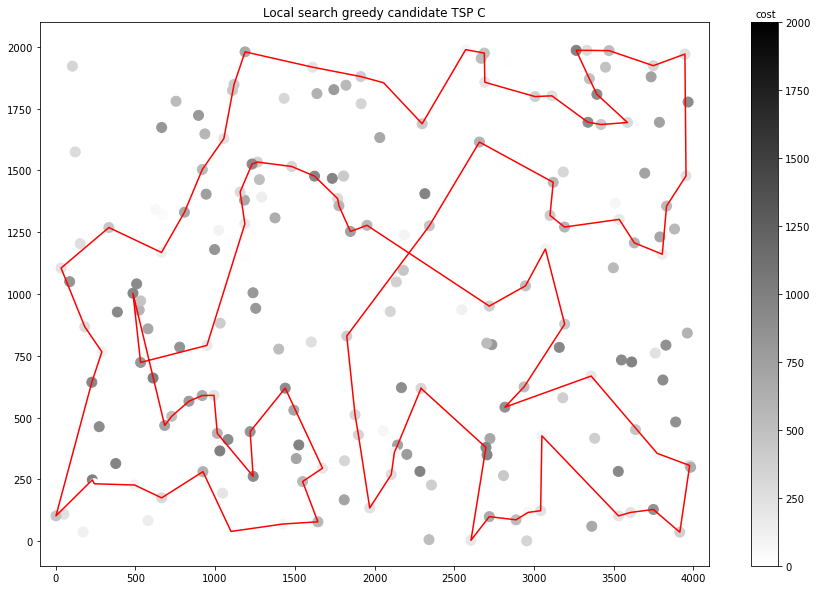

In [13]:
summarize(local_search_greedy_candidate, data, 'Local search greedy candidate TSP C')

200


  0%|          | 0/200 [00:00<?, ?it/s]

Local search steepest candidate TSP C:
average time: 1.6254752111434936	worst time: 1.9297447204589844	best time: 1.3622028827667236
average score: 74964.555	worst score: 80258.0	best score: 68609.0
Best solution:


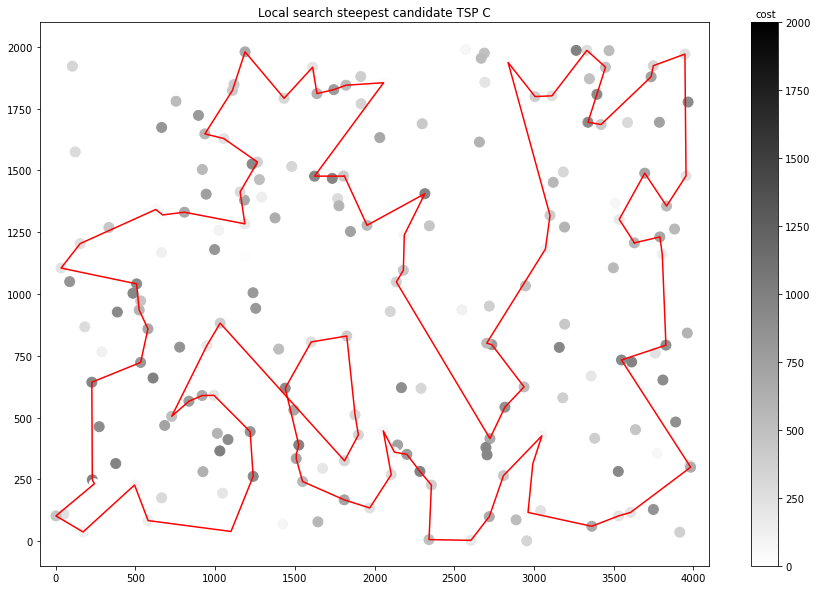

In [14]:
summarize(local_search_steepest_candidate, data, 'Local search steepest candidate TSP C')

In [16]:
data = np.loadtxt('TSPD.csv', dtype=int, delimiter=';')

200


  0%|          | 0/200 [00:00<?, ?it/s]

Local search greedy candidate TSP D:
average time: 2.7592298328876494	worst time: 3.3776679039001465	best time: 2.1319427490234375
average score: 74707.78	worst score: 81234.0	best score: 66842.0
Best solution:


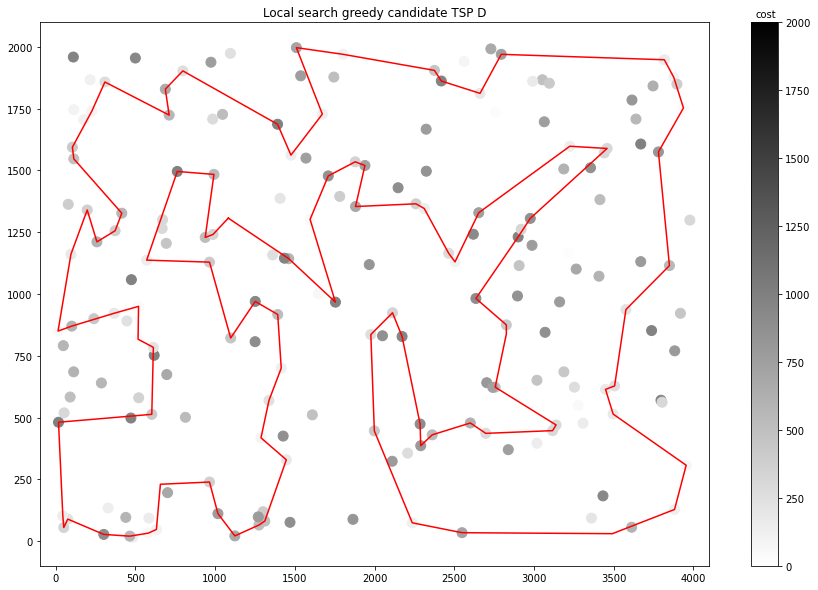

In [17]:
summarize(local_search_greedy_candidate, data, 'Local search greedy candidate TSP D')

200


  0%|          | 0/200 [00:00<?, ?it/s]

Local search greedy candidate TSP D:
average time: 1.8750273156166077	worst time: 2.25187611579895	best time: 1.548058032989502
average score: 73245.595	worst score: 81090.0	best score: 67114.0
Best solution:


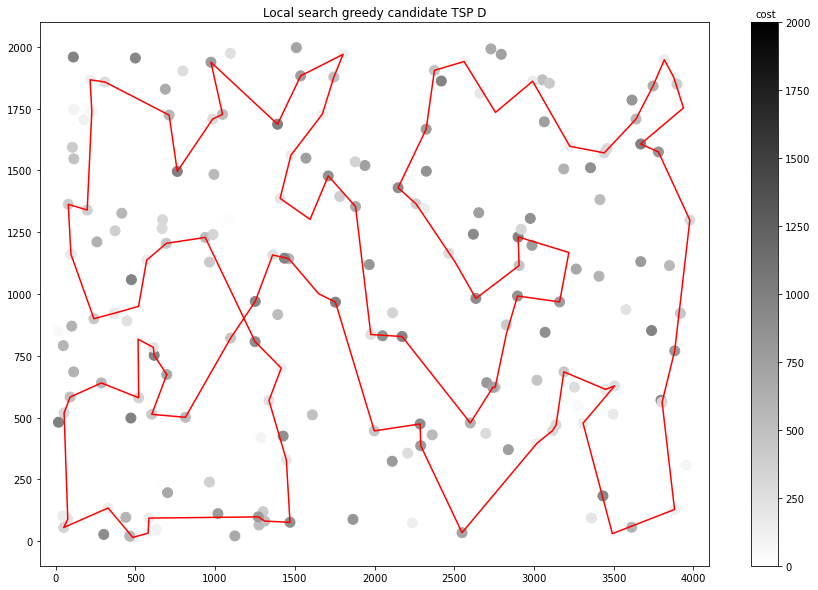

In [18]:
summarize(local_search_steepest_candidate, data, 'Local search greedy candidate TSP D')